Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 100, 64)   │    640,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 100)       │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 100, 64)   │    640,000 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 128),     │     98,816 │ embedding_4[0][0… │
│                     │ (None, 128),      │            │ not_equal_4[0][0] │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 100,      │     98,816 │ embedding_5[0][0… │
│                     │ 128), (None,      │            │ lstm_4[0][1],     │
│                     │ 128), (None,      │            │ lstm_4[0][2]      │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100,       │  1,290,000 │ lstm_5[0][0]      │
│                     │ 10000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,767,632 (10.56 MB)

 Trainable params: 2,767,632 (10.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 1220s 3s/step - accuracy: 0.0610 - loss: 6.8113 - val_accuracy: 0.0827 - val_loss: 5.1909
Epoch 2/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 1190s 3s/step - accuracy: 0.1902 - loss: 4.8091 - val_accuracy: 0.5992 - val_loss: 3.3144
Epoch 3/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 1206s 3s/step - accuracy: 0.6526 - loss: 2.8812 - val_accuracy: 0.7716 - val_loss: 1.9160


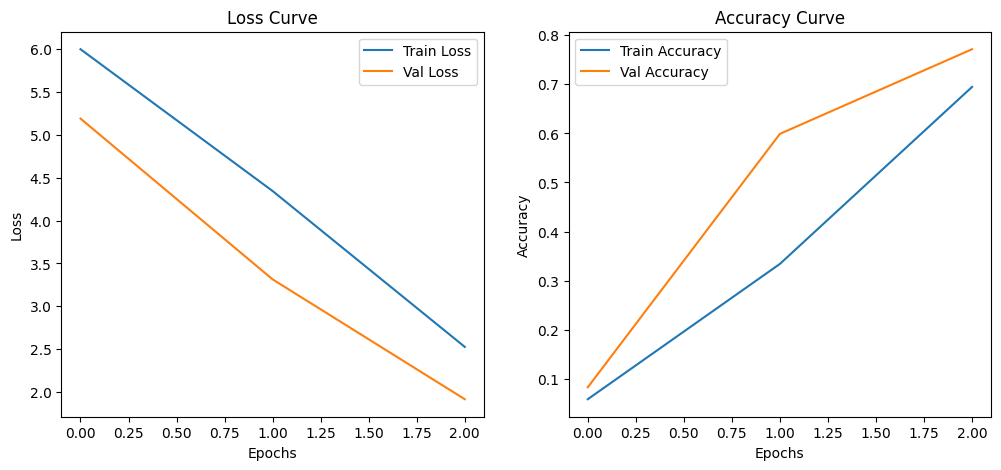

782/782 ━━━━━━━━━━━━━━━━━━━━ 776s 991ms/step - accuracy: 0.7679 - loss: 1.9026

Test Loss: 1.9016655683517456
Test Accuracy: 76.84 %


In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

# ---- Load Dataset ----
vocab_size = 10000
max_len = 100

(x_train, _), (x_test, _) = imdb.load_data(num_words=vocab_size)
x_train = pad_sequences(x_train, maxlen=max_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_len, padding='post')

# ---- Seq2Seq Model ----
embed_dim = 64
latent_dim = 128

# Encoder
encoder_in = Input(shape=(max_len,))
x = Embedding(vocab_size, embed_dim, mask_zero=True)(encoder_in)
_, h, c = LSTM(latent_dim, return_state=True)(x)

# Decoder
decoder_in = Input(shape=(max_len,))
y = Embedding(vocab_size, embed_dim, mask_zero=True)(decoder_in)
y, _, _ = LSTM(latent_dim, return_sequences=True, return_state=True)(
          y, initial_state=[h, c])

out = Dense(vocab_size, activation='softmax')(y)

# Final model
model = Model([encoder_in, decoder_in], out)
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

# ---- Prepare decoder inputs ----
decoder_input = x_train.copy()
decoder_input[:, 0] = 1          # start token
decoder_target = x_train[..., None]

# ---- Train ----
history = model.fit(
    [x_train, decoder_input],
    decoder_target,
    epochs=3,
    batch_size=64,
    validation_split=0.1
)

# ---- Plot Loss and Accuracy ----
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

# ---- Test Accuracy ----
decoder_input_test = x_test.copy()
decoder_input_test[:, 0] = 1

decoder_target_test = x_test[..., None]

test_loss, test_acc = model.evaluate(
    [x_test, decoder_input_test],
    decoder_target_test
)

print("\nTest Loss:", test_loss)
print("Test Accuracy:", round(test_acc * 100, 2), "%")
